# **Практика 5: Атака с ограниченной памятью (`PGD` - `Projected Gradient Descent`)**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Карпейкин Владислав Анатольевич**

##**Цель задания:**
 Изучить одну из наиболее мощных атак на модели ИИ — атаку `Projected Gradient Descent` (`PGD`).
 Научиться использовать `PGD` для создания противоречивых примеров и оценить её влияние на обученные модели.

##**Задачи:**
1. Загрузить ранее обученную модель на датасете `MNIST`.
2. Изучить теоретические основы атаки `PGD`.
3. Реализовать атаку `PGD` с помощью фреймворка `Foolbox`.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

##**Шаги выполнения:**

###**Шаг 1: Загрузка обученной модели и данных MNIST**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST:
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot:
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели:
model = tf.keras.models.load_model('/content/mnist_model.h5')
# Проверка точности модели на обычных данных:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9752 - loss: 0.0817
Test accuracy on clean images: 0.9778000116348267


### Шаг 2: Теория атаки `Projected Gradient Descent` (`PGD`):

Атака Projected Gradient Descent (`PGD`) — это расширение `FGSM` (`Fast Gradient Sign Method`), где атака выполняется итеративно. На каждой итерации добавляются небольшие изменения к входным данным в направлении увеличения ошибки модели.

После каждой итерации результат "проецируется" на допустимое пространство для ограничивания размера изменений, что позволяет сохранять противоречивый пример в пределах определенной нормы (например, L∞).

### Шаг 3: Реализация атаки `PGD` с использованием `Foolbox`

Установка `Foolbox`:

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00


Реализация атаки `PGD`:

Как пример атака происходит на первые 5 изображений:

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


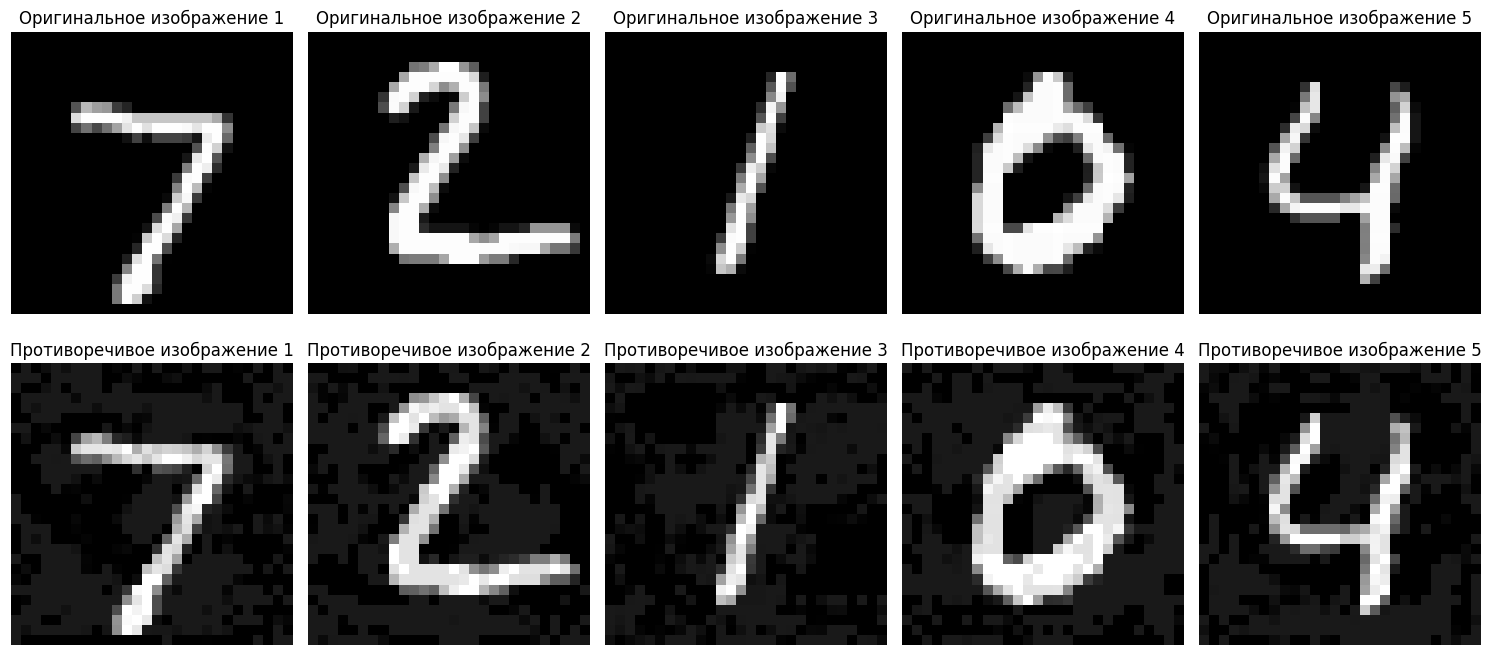

In [3]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки PGD
attack = fb.attacks.LinfPGD()

# Количество изображений для атаки
num_images = 5

# Создание подграфиков для отображения результатов
plt.figure(figsize=(15, 7))

for i in range(num_images):
    # Выбор изображения для атаки
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)

    # Выполнение атаки
    adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.1)

    # Отображение оригинального и противоречивого изображений
    plt.subplot(2, num_images, i + 1)
    plt.title(f"Оригинальное изображение {i+1}")
    plt.imshow(image[0].numpy(), cmap="gray")
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.title(f"Противоречивое изображение {i+1}")
    plt.imshow(adversarial_image[0].numpy(), cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 4: Оценка модели на противоречивых примерах

 Теперь мы проверим, как сильно атака `PGD` влияет на точность модели. Мы создадим набор противоречивых примеров и оценим производительность модели на этих данных. В качестве данных возьмем первые 1000 изображений для экономии времени обработки

In [4]:
max_images = 1000
num_images_to_process = min(len(test_images), max_images)
adversarial_images = []

for i in range(num_images_to_process):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:num_images_to_process])
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0341 - loss: 8.6234 
Accuracy on adversarial examples (PGD): 0.035999998450279236


### Шаг 5: Сравнение результатов

Модель сильно уязвима к атакам типа `PGD`(`Projected Gradient Descent`). Изначальная точность была равна ~97%, однако после реализации атаки наблюдается резкое снижение точности до 3%, что свидетельствует о том, что модель не устойчива к небольшим, но целенаправленным изменениям входных данных, которые с легкостью приводят к ошибкам в ней